In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [10]:
df1 = pd.read_csv("./data/SPX_Real.csv", index_col=False)
df1.columns = ['Timestamp', 'Close']
df1.set_index("Timestamp", inplace=True)
df1.index = pd.to_datetime(df1.index, format='%d-%m-%Y')
df2 = pd.read_csv("./data/AAPL_Real.csv")
df2.columns = ['Timestamp', 'Close']
df2.set_index("Timestamp", inplace=True)
df2.index = pd.to_datetime(df2.index, format='%d-%m-%Y')
df3 = pd.read_csv("./data/TWSE_Real.csv")
df3.columns = ['Timestamp', 'Close']
df3.set_index("Timestamp", inplace=True)
df3.index = pd.to_datetime(df3.index, format='%m/%d/%Y')

In [16]:
df2.describe()

,Close
count,8831.000000
mean,30.925664
std,55.147736
min,0.116000
25%,0.384000
50%,3.356000
75%,29.056500
max,259.020000


In [3]:
from sklearn.preprocessing import MinMaxScaler
def create_dataset(series, window_size, pred_length):
    X, y = [], []
    # Use +1 so that the last index is valid
    for i in range(len(series) - window_size - pred_length + 1):
        X.append(series[i : i + window_size])
        # Correct slice for the next pred_length points
        y.append(series[i + window_size : i + window_size + pred_length])
    

    return np.array(X), np.array(y)

def get_data_for_period(df, window_size = 20, pred_length = 1):    
    val_start = int(len(df) * 0.8)
    test_start = val_start + int(len(df) * 0.1)
    train_data = df.iloc[:val_start]
    val_data   = df.iloc[val_start:test_start]
    test_data  = df.iloc[test_start:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_values = train_data['Close'].values.reshape(-1, 1)
    scaler.fit(train_values)
    
    # Transform the 'Close' column in all splits using the same scaler
    train_scaled = scaler.transform(train_data['Close'].values.reshape(-1, 1)).flatten()
    val_scaled   = scaler.transform(val_data['Close'].values.reshape(-1, 1)).flatten()
    test_scaled  = scaler.transform(test_data['Close'].values.reshape(-1, 1)).flatten()
    
    # Create sliding-window datasets from the scaled data
    X_train, y_train = create_dataset(train_scaled, window_size, pred_length)
    X_val, y_val     = create_dataset(val_scaled, window_size, pred_length)
    X_test, y_test   = create_dataset(test_scaled, window_size, pred_length)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler

In [4]:
dfs = {'SPX': df1, 'AAPL': df2, 'TWSE': df3}

In [5]:
import torch
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape (N, 55)
        self.Y = Y  # shape (N, pred_length)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # (55,) --> (55, 1)
        past_vals = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(-1)
        future_vals = torch.tensor(self.Y[idx], dtype=torch.float32).unsqueeze(-1)

        return {
            "past_values": past_vals,      # shape (55, 1)
            "future_values": future_vals   # shape (pred_length,)
        }


In [8]:
from transformers import PatchTSTConfig, PatchTSTForPrediction
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

res = {}
window_size = 55
for name in dfs:
    for pred_length in [1, 5, 10]:
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = get_data_for_period(dfs[name], window_size, pred_length)
        train_dataset = TimeSeriesDataset(X_train, y_train)
        valid_dataset = TimeSeriesDataset(X_val, y_val)
        test_dataset  = TimeSeriesDataset(X_test, y_test)

        loader = DataLoader(train_dataset, batch_size=32)
        batch = next(iter(loader))
        print("past_values batch shape:", batch["past_values"].shape)
        # should be (32, 1, 55)
        print("future_values batch shape:", batch["future_values"].shape)
        # should be (32, 5)
        config = PatchTSTConfig(context_length = 55, prediction_length = pred_length, num_input_channels=1)
        model = PatchTSTForPrediction(config)
        training_args = TrainingArguments(
            output_dir=f"./20_pochs_patch_tst_results_{name}_pred_length_{pred_length}",
            evaluation_strategy="epoch",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            num_train_epochs=20,
            auto_find_batch_size = True,
            lr_scheduler_type = "cosine",
            logging_steps=10,
            save_strategy="epoch",
            label_smoothing_factor = 0.1
        )

        trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,   
        )

        # 7. Train
        trainer.train()

        # 8. Evaluate on test set
        results = trainer.evaluate(test_dataset)
        print("Test results:", results)
        res[f"{name}_pred_length_{pred_length}"] = results

print(res)


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 05:55:37] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 1, 1])


[codecarbon WARNING @ 05:55:38] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000100,No log
2,0.000000,No log
3,0.000100,No log
4,0.000100,No log
5,0.000300,No log
6,0.000000,No log
7,0.000100,No log
8,0.000000,No log
9,0.000000,No log
10,0.000000,No log


[codecarbon WARNING @ 05:59:05] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 05:59:05] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.202, 'eval_samples_per_second': 4103.047, 'eval_steps_per_second': 128.684, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 5, 1])


[codecarbon WARNING @ 05:59:06] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000100,No log
2,0.000100,No log
3,0.000100,No log
4,0.000100,No log
5,0.000100,No log
6,0.000100,No log
7,0.000100,No log
8,0.000100,No log
9,0.000100,No log
10,0.000100,No log


[codecarbon WARNING @ 06:02:34] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:02:34] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.2062, 'eval_samples_per_second': 4000.274, 'eval_steps_per_second': 126.069, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 10, 1])


[codecarbon WARNING @ 06:02:34] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000200,No log
2,0.000100,No log
3,0.000100,No log
4,0.000100,No log
5,0.000100,No log
6,0.000100,No log
7,0.000100,No log
8,0.000100,No log
9,0.000100,No log
10,0.000100,No log


[codecarbon WARNING @ 06:05:59] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:06:00] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.1964, 'eval_samples_per_second': 4175.342, 'eval_steps_per_second': 132.389, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 1, 1])


[codecarbon WARNING @ 06:06:00] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000000,No log
2,0.000000,No log
3,0.000000,No log
4,0.000000,No log
5,0.000000,No log
6,0.000000,No log
7,0.000000,No log
8,0.000000,No log
9,0.000000,No log
10,0.000000,No log


[codecarbon WARNING @ 06:09:27] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:09:27] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.2262, 'eval_samples_per_second': 3664.232, 'eval_steps_per_second': 114.922, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 5, 1])


[codecarbon WARNING @ 06:09:28] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000100,No log
2,0.000100,No log
3,0.000100,No log
4,0.000100,No log
5,0.000100,No log
6,0.000100,No log
7,0.000100,No log
8,0.000100,No log
9,0.000100,No log
10,0.000100,No log


[codecarbon WARNING @ 06:12:50] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:12:50] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.2071, 'eval_samples_per_second': 3984.447, 'eval_steps_per_second': 125.57, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 10, 1])


[codecarbon WARNING @ 06:12:51] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000100,No log
2,0.000100,No log
3,0.000100,No log
4,0.000100,No log
5,0.000100,No log
6,0.000100,No log
7,0.000100,No log
8,0.000100,No log
9,0.000100,No log
10,0.000100,No log


[codecarbon WARNING @ 06:16:13] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:16:14] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.2141, 'eval_samples_per_second': 3830.867, 'eval_steps_per_second': 121.467, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 1, 1])


[codecarbon WARNING @ 06:16:14] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000200,No log
2,0.000200,No log
3,0.000200,No log
4,0.000200,No log
5,0.000200,No log
6,0.000200,No log
7,0.000200,No log
8,0.000200,No log
9,0.000100,No log
10,0.000100,No log


[codecarbon WARNING @ 06:19:43] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:19:43] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.1951, 'eval_samples_per_second': 4346.44, 'eval_steps_per_second': 138.389, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 5, 1])


[codecarbon WARNING @ 06:19:43] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000500,No log
2,0.000400,No log
3,0.000400,No log
4,0.000300,No log
5,0.000400,No log
6,0.000300,No log
7,0.000400,No log
8,0.000400,No log
9,0.000500,No log
10,0.000400,No log


[codecarbon WARNING @ 06:23:09] Another instance of codecarbon is already running. Exiting.


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[codecarbon ERROR @ 06:23:09] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


Test results: {'eval_runtime': 0.2432, 'eval_samples_per_second': 3470.295, 'eval_steps_per_second': 111.017, 'epoch': 20.0}
past_values batch shape: torch.Size([32, 55, 1])
future_values batch shape: torch.Size([32, 10, 1])


[codecarbon WARNING @ 06:23:10] Another instance of codecarbon is already running. Exiting.


Epoch,Training Loss,Validation Loss
1,0.000800,No log
2,0.000600,No log
3,0.000700,No log
4,0.000600,No log
5,0.000600,No log
6,0.000600,No log
7,0.000600,No log
8,0.000900,No log
9,0.000600,No log
10,0.000700,No log


[codecarbon WARNING @ 06:26:42] Another instance of codecarbon is already running. Exiting.


Test results: {'eval_runtime': 0.2493, 'eval_samples_per_second': 3365.056, 'eval_steps_per_second': 108.291, 'epoch': 20.0}
{'SPX_pred_length_1': {'eval_runtime': 0.202, 'eval_samples_per_second': 4103.047, 'eval_steps_per_second': 128.684, 'epoch': 20.0}, 'SPX_pred_length_5': {'eval_runtime': 0.2062, 'eval_samples_per_second': 4000.274, 'eval_steps_per_second': 126.069, 'epoch': 20.0}, 'SPX_pred_length_10': {'eval_runtime': 0.1964, 'eval_samples_per_second': 4175.342, 'eval_steps_per_second': 132.389, 'epoch': 20.0}, 'AAPL_pred_length_1': {'eval_runtime': 0.2262, 'eval_samples_per_second': 3664.232, 'eval_steps_per_second': 114.922, 'epoch': 20.0}, 'AAPL_pred_length_5': {'eval_runtime': 0.2071, 'eval_samples_per_second': 3984.447, 'eval_steps_per_second': 125.57, 'epoch': 20.0}, 'AAPL_pred_length_10': {'eval_runtime': 0.2141, 'eval_samples_per_second': 3830.867, 'eval_steps_per_second': 121.467, 'epoch': 20.0}, 'TWSE_pred_length_1': {'eval_runtime': 0.1951, 'eval_samples_per_second':

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import torch
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.utils.data import DataLoader

for name in dfs:
    for pred_length in [1, 5, 10]:
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = get_data_for_period(dfs[name], window_size, pred_length)
        train_dataset = TimeSeriesDataset(X_train, y_train)
        valid_dataset = TimeSeriesDataset(X_val, y_val)
        test_dataset  = TimeSeriesDataset(X_test, y_test)

        # Define paths and variables
        results_folder = f"./20_pochs_patch_tst_results_{name}_pred_length_{pred_length}"

        # List all checkpoint directories
        checkpoint_dirs = [os.path.join(results_folder, d) for d in os.listdir(results_folder) if d.startswith("checkpoint-")]

        # Evaluate each model and track performance
        best_checkpoint = None
        best_score = float("inf")
        
        # Create a DataLoader for validation
        val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


        for checkpoint_path in checkpoint_dirs:
            # Load the model
            model = PatchTSTForPrediction.from_pretrained(checkpoint_path)
            model.eval()
            all_preds = []
            all_labels = []

            for batch in val_loader:
                # batch is { "past_values": <tensor>, "future_values": <tensor> }
                # For PatchTSMixerForPrediction, you can do:

                with torch.no_grad():
                    outputs = model(**batch)  # Pass the dict as keyword args
                    # outputs is a model-specific output object (e.g. TSModelOutput)

                # Usually, predictions are in outputs.predictions
                
                # Collect predictions and labels
                all_preds.append(outputs.prediction_outputs.flatten())
                all_labels.append(batch["future_values"].numpy().flatten())


            # Concatenate predictions and labels if needed
            all_preds = np.concatenate(all_preds, axis=0)
            all_labels = np.concatenate(all_labels, axis=0)

            # Calculate metric (e.g., MSE)
            score = mean_squared_error(all_labels, all_preds)

            # Track the best model
            if score < best_score:
                best_score = score
                best_checkpoint = checkpoint_path

        print(f"\nBest model is from checkpoint: {best_checkpoint} with MSE: {best_score:.4f}")

        # # Load the best model
        best_model = PatchTSTForPrediction.from_pretrained(best_checkpoint)


        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        all_preds = []
        all_labels = []

        for batch in test_loader:
            # batch is { "past_values": <tensor>, "future_values": <tensor> }
            # For PatchTSMixerForPrediction, you can do:

            with torch.no_grad():
                outputs = model(**batch)  # Pass the dict as keyword args
                # outputs is a model-specific output object (e.g. TSModelOutput)

            # Usually, predictions are in outputs.predictions
            
            # Collect predictions and labels
            all_preds.append(outputs.prediction_outputs.flatten())
            all_labels.append(batch["future_values"].numpy().flatten())


        # Concatenate predictions and labels if needed
        all_preds = np.concatenate(all_preds, axis=0).reshape(-1, 1)
        all_labels = np.concatenate(all_labels, axis=0).reshape(-1, 1)
        
        print(all_preds.shape)

        preds_flat = scaler.inverse_transform(all_preds)
        labels_flat = scaler.inverse_transform(all_labels)

        mse  = mean_squared_error(labels_flat, preds_flat)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(labels_flat, preds_flat)

        mask = labels_flat != 0
        mape = (np.mean(np.abs((labels_flat[mask] - preds_flat[mask]) / labels_flat[mask])) * 100
                if np.any(mask) else float('inf'))
        r2   = r2_score(labels_flat, preds_flat)

        
        print(f"{name} RMSE: {rmse} for {pred_length}")
        print(f"{name} MAE: {mae} for {pred_length}")
        print(f"{name} MAPE: {mape} for {pred_length}")
        print(f"{name} r2: {r2} for {pred_length}")
        


Best model is from checkpoint: ./20_pochs_patch_tst_results_SPX_pred_length_1/checkpoint-2860 with MSE: 0.0003
(829, 1)
SPX RMSE: 51.365081787109375 for 1
SPX MAE: 39.18186950683594 for 1
SPX MAPE: 0.8786717429757118 for 1
SPX r2: 0.993878185749054 for 1

Best model is from checkpoint: ./20_pochs_patch_tst_results_SPX_pred_length_5/checkpoint-2190 with MSE: 0.0007
(4125, 1)
SPX RMSE: 86.93843078613281 for 5
SPX MAE: 66.21431732177734 for 5
SPX MAPE: 1.4752637594938278 for 5
SPX r2: 0.9823272824287415 for 5

Best model is from checkpoint: ./20_pochs_patch_tst_results_SPX_pred_length_10/checkpoint-876 with MSE: 0.0012
(8200, 1)
SPX RMSE: 118.01811981201172 for 10
SPX MAE: 96.50824737548828 for 10
SPX MAPE: 2.114332653582096 for 10
SPX r2: 0.9671787023544312 for 10

Best model is from checkpoint: ./20_pochs_patch_tst_results_AAPL_pred_length_1/checkpoint-3080 with MSE: 0.0016
(829, 1)
AAPL RMSE: 3.517345666885376 for 1
AAPL MAE: 2.7097651958465576 for 1
AAPL MAPE: 1.553931925445795 for 1

torch.Size([10])


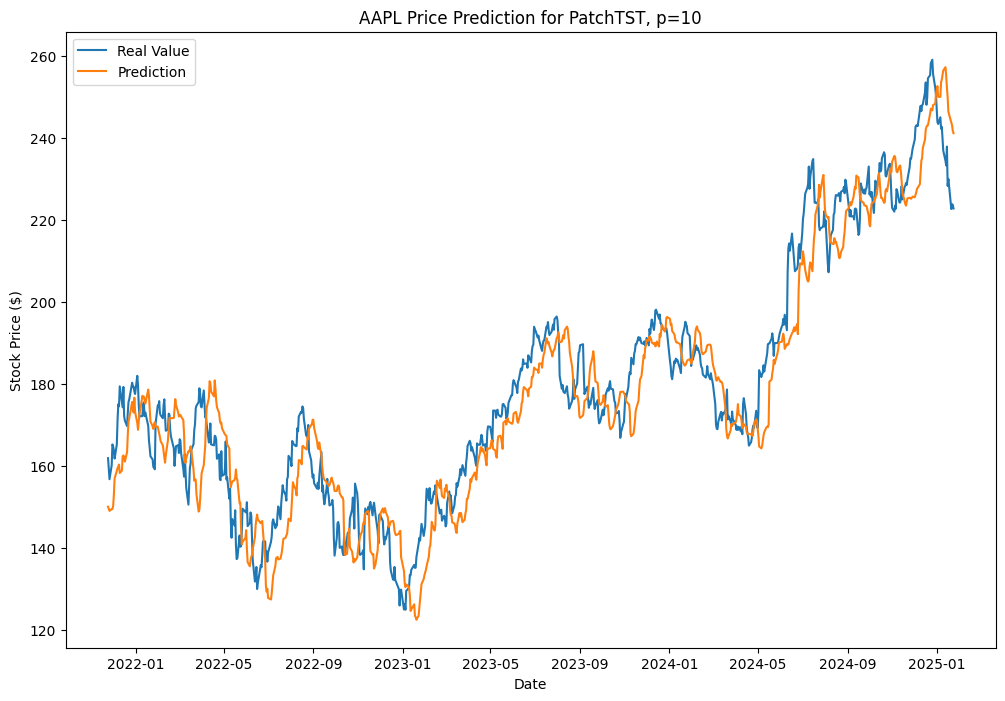

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import torch
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.utils.data import DataLoader

for name in ['AAPL']:
    for pred_length in [10]:
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = get_data_for_period(dfs[name], window_size, pred_length)
        train_dataset = TimeSeriesDataset(X_train, y_train)
        valid_dataset = TimeSeriesDataset(X_val, y_val)
        test_dataset  = TimeSeriesDataset(X_test, y_test)

        # Define paths and variables
        results_folder = f"./20_pochs_patch_tst_results_{name}_pred_length_{pred_length}"

        # List all checkpoint directories
        checkpoint_dirs = [os.path.join(results_folder, d) for d in os.listdir(results_folder) if d.startswith("checkpoint-")]

        # Evaluate each model and track performance
        best_checkpoint = "./20_pochs_patch_tst_results_AAPL_pred_length_10/checkpoint-876" 
        # best_score = float("inf")
        
        # # # Create a DataLoader for validation
        # val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


        # for checkpoint_path in checkpoint_dirs:
        #     # Load the model
        #     model = PatchTSTForPrediction.from_pretrained(checkpoint_path)
        #     model.eval()
        #     all_preds = []
        #     all_labels = []

        #     for batch in val_loader:
        #         # batch is { "past_values": <tensor>, "future_values": <tensor> }
        #         # For PatchTSMixerForPrediction, you can do:

        #         with torch.no_grad():
        #             outputs = model(**batch)  # Pass the dict as keyword args
        #             # outputs is a model-specific output object (e.g. TSModelOutput)

        #         # Usually, predictions are in outputs.predictions
                
        #         # Collect predictions and labels
        #         all_preds.append(outputs.prediction_outputs.flatten())
        #         all_labels.append(batch["future_values"].numpy().flatten())


        #     # Concatenate predictions and labels if needed
        #     all_preds = np.concatenate(all_preds, axis=0)
        #     all_labels = np.concatenate(all_labels, axis=0)

        #     # Calculate metric (e.g., MSE)
        #     score = mean_squared_error(all_labels, all_preds)

        #     # Track the best model
        #     if score < best_score:
        #         best_score = score
        #         best_checkpoint = checkpoint_path

        # print(f"\nBest model is from checkpoint: {best_checkpoint} with MSE: {best_score:.4f}")

        # # Load the best model
        best_model = PatchTSTForPrediction.from_pretrained(best_checkpoint)


        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        all_preds = []
        all_labels = []

        for batch in test_loader:
            # batch is { "past_values": <tensor>, "future_values": <tensor> }
            # For PatchTSMixerForPrediction, you can do:

            with torch.no_grad():
                outputs = model(**batch)  # Pass the dict as keyword args
                # outputs is a model-specific output object (e.g. TSModelOutput)

            # Usually, predictions are in outputs.predictions
            
            # Collect predictions and labels
            all_preds.append(outputs.prediction_outputs.squeeze(-1).flatten())
            all_labels.append(batch["future_values"].squeeze(-1).flatten())

        print(all_preds[0].shape)

        preds_test = []
        labels_test = []

        for i in range(len(all_preds)):
            preds_test.append(all_preds[i][-1])
            labels_test.append(all_labels[i][-1])
        # Concatenate predictions and labels if needed
        all_preds = scaler.inverse_transform(np.array(preds_test).reshape(-1, 1))
        all_labels = scaler.inverse_transform(np.array(labels_test).reshape(-1, 1))
        plt.figure(figsize=(12,8))
        plt.plot(dfs['AAPL'].index[-794:], all_labels[-794:], label='Real Value')
        plt.plot(dfs['AAPL'].index[-794:], all_preds[-794:], label='Prediction')
        plt.title(f"AAPL Price Prediction for PatchTST, p=10")
        plt.xlabel('Date')
        plt.ylabel('Stock Price ($)')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()
        plt.close()